# Optimized Cython MCMC implementation

The implementation in the previous section still used `numpy.random` calls, which go through Python.

In this notebook, we'll demonstrate creating a separate Cython package called `cython_mcmc` that uses another Cython package named `mt19937` for faster random number generation.

We will see a significant speedup for the MCMC sampler as a result of our efforts.

## First step -- compile external packages and run perfomance tests

In [ ]:
%%bash
cd ./mt19937
python ./setup.py develop
cython -a ./srs/mt19937.pyx

In [1]:
%%bash
cd cython_mcmc
python ./setup.py develop
cython -a ./cython_mcmc/mcmc.pyx

Compiling cython_mcmc/mcmc.pyx because it changed.
[1/1] Cythonizing cython_mcmc/mcmc.pyx
running develop
running egg_info
writing cython_mcmc.egg-info/PKG-INFO
writing dependency_links to cython_mcmc.egg-info/dependency_links.txt
writing top-level names to cython_mcmc.egg-info/top_level.txt
reading manifest file 'cython_mcmc.egg-info/SOURCES.txt'
writing manifest file 'cython_mcmc.egg-info/SOURCES.txt'
running build_ext
building 'cython_mcmc.mcmc' extension
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/opt/conda/lib/python3.6/site-packages/numpy/core/include -I../mt19937/srs -I/opt/conda/include/python3.6m -c cython_mcmc/mcmc.c -o build/temp.linux-x86_64-3.6/cython_mcmc/mcmc.o
gcc -pthread -shared -L/opt/conda/lib -Wl,-rpath=/opt/conda/lib,--no-as-needed -L/opt/conda/lib -Wl,-rpath=/opt/conda/lib,--no-as-needed build/temp.linux-x86_64-3.6/cython_mcmc/mcmc.o -L/opt/conda/lib -lpython3.6m -o build/lib.linux-x86_64-3.6/cython_mc

In file included from /opt/conda/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1788:0,
                 from /opt/conda/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /opt/conda/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from cython_mcmc/mcmc.c:453:
/opt/conda/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it by " \
  ^


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy.stats import norm

from cython_mcmc import mcmc

np.random.seed(123)
data = np.random.randn(20)

In [4]:
%timeit mcmc.log_sampler(data, samples=15000, mu_init=1.0)

6.13 ms ± 99.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


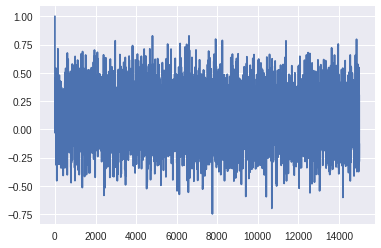

In [18]:
posterior = mcmc.log_sampler(data, samples=15000, mu_init=1.0)
plt.plot(posterior);

In [19]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

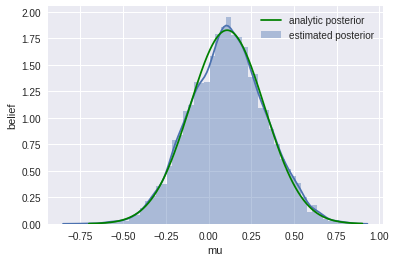

In [20]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.7, .9, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();

## Standard error in $\mu$ shrinks as more data is collected

In [41]:
%%time
data_2000 = np.random.randn(2000)
posterior_2000 = mcmc.log_sampler(data_2000, samples=150000, mu_init=1.0)

CPU times: user 580 ms, sys: 0 ns, total: 580 ms
Wall time: 583 ms


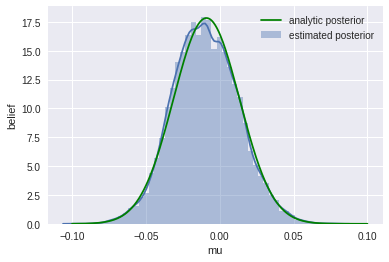

In [42]:
ax = plt.subplot()

sns.distplot(posterior_2000[500::5], ax=ax, label='estimated posterior')
x = np.linspace(-.1, .1, 500)
post = calc_posterior_analytical(data_2000, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();

## `log_sampler()` using external library

In [ ]:
%%html
./cython_mcmc/cython_mcmc/mcmc.html

### Worth noting

* `from [...] cimport RandomState`
* `from [...] import RandomState`
* `sample_norm()` and `accept_p()` implementations.
* `norm_logpdf()` implementation uses raw C buffers.

## `RandomState` extension type

Cython-level compile-time interface defined in `mt19937.pxd`:

In [ ]:
!cat ./mt19937/srs/mt19937.pxd | nl

In [ ]:
%%html
./mt19937/srs/mt19937.html

## Putting it all together in `setup.py` with `cythonize()`

* We use a `setup.py` script in the `cython_mcmc` package to compile everything together.
* We specify all the `mcmc.pyx` external Cython and C dependencies in an `Extension()` object.
* We use the `Cython.Build.cythonize()` command to pull everything together and compile things for us.
* The `python setup.py develop` command is what kicks things off for us, and produces the `mcmc.so` shared object file.

In [ ]:
%cat ./cython_mcmc/setup.py